#  Загрузка и предобработка данных

## Загрузка и первичный осмотр данных

In [1]:
import pandas as pd


In [2]:
orders_df = pd.read_csv('task_2_data/orders.csv')
payments_df = pd.read_csv('task_2_data/payments.csv')
plans_df = pd.read_csv('task_2_data/plan.csv')

In [3]:
orders_df.head(5)

,order_id,created_at,put_at,closed_at,issued_sum
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0
1,400005838,2022-06-02 00:10:22.997,2022-06-02 15:41:33.267,2022-06-02 17:38:43.917,20000.0
2,400007915,2022-06-02 00:18:04.000,2022-06-05 19:17:38.547,2022-06-21 21:55:51.877,5820.0
3,400008952,2022-06-02 00:22:07.000,2022-06-03 14:25:18.033,2022-07-12 10:47:46.307,9000.0
4,400009027,2022-06-02 00:25:39.000,2022-06-02 00:40:40.320,2022-06-22 14:15:07.423,5000.0


In [4]:
payments_df.head(5)

,order_id,paid_at,paid_sum
0,400013633,2022-06-02 00:48:13.800,2500.0
1,400018480,2022-06-02 01:52:05.707,1070.0
2,400032001,2022-06-02 04:55:40.307,4200.0
3,400033195,2022-06-02 05:44:23.480,2850.0
4,400039407,2022-06-02 06:53:54.503,10100.0


In [5]:
plans_df.head(5)

,order_id,plan_at,plan_sum_total
0,400001732,2022-06-02,5600.0
1,400001732,2022-07-02,9450.0
2,400001732,2022-08-01,12170.0
3,400001732,2022-08-31,14890.0
4,400001732,2022-09-30,17610.0


In [6]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55748 entries, 0 to 55747
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_id    55748 non-null  int64  
 1   created_at  55748 non-null  object 
 2   put_at      55748 non-null  object 
 3   closed_at   46472 non-null  object 
 4   issued_sum  55748 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 2.1+ MB


In [7]:
payments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143284 entries, 0 to 143283
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   order_id  143284 non-null  int64  
 1   paid_at   143284 non-null  object 
 2   paid_sum  143284 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.3+ MB


In [8]:
plans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420282 entries, 0 to 420281
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   order_id        420282 non-null  int64  
 1   plan_at         420282 non-null  object 
 2   plan_sum_total  420282 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 9.6+ MB


## Преобразование дат

In [9]:
# Преобразование дат
plans_df['plan_at'] = pd.to_datetime(plans_df['plan_at'])
payments_df['paid_at'] = pd.to_datetime(payments_df['paid_at']).dt.date
payments_df['paid_at'] = pd.to_datetime(payments_df['paid_at'])

## Обработка пропусков

In [10]:
# Проверка пропусков
print("Пропуски в plan_at:", plans_df['plan_at'].isnull().sum())
print("Пропуски в paid_at:", payments_df['paid_at'].isnull().sum())

Пропуски в plan_at: 0
Пропуски в paid_at: 0


## Проверка дубликатов

In [11]:
# Проверка дубликатов
print("Дубликаты в plans_sorted:", plans_df.duplicated(subset=['order_id', 'plan_at']).sum())
print("Дубликаты в payments_sorted:", payments_df.duplicated(subset=['order_id', 'paid_at']).sum())

Дубликаты в plans_sorted: 0
Дубликаты в payments_sorted: 8596


In [12]:
# Удаление дубликатов
plans_df = plans_df.drop_duplicates(subset=['order_id', 'plan_at'])
payments_df = payments_df.drop_duplicates(subset=['order_id', 'paid_at'])

## Агрегация данных по месяцам
Чтобы сравнить плановые и фактические платежи, сгруппируем их по месяцам.

In [13]:
# Для плановых платежей
plans_df["plan_month"] = plans_df["plan_at"].dt.to_period("M")
monthly_plans = plans_df.groupby(["order_id", "plan_month"])["plan_sum_total"].sum().reset_index()

In [14]:
# Для фактических платежей:
payments_df["paid_month"] = payments_df["paid_at"].dt.to_period("M")
monthly_payments = payments_df.groupby(["order_id", "paid_month"])["paid_sum"].sum().reset_index()

## Объединение данных через 
Сопоставим плановые и фактические платежи по order_id и месяцу

In [15]:
merged = pd.merge(
    monthly_plans,
    monthly_payments,
    left_on=["order_id", "plan_month"],
    right_on=["order_id", "paid_month"],
    how="left"
)

## Обработка пропущенных значений
Если платежей в каком-то месяце нет, заполним их нулями:

In [16]:
merged["paid_sum"] = merged["paid_sum"].fillna(0)

##  Расчет просрочек

Добавим флаг просрочки для каждого месяца:

In [17]:
merged["is_delinquent"] = (merged["paid_sum"] < merged["plan_sum_total"]).astype(int)

## Анализ динамики просрочек

In [18]:
# Группировка по месяцам
delinquency_rate = merged.groupby("plan_month")["is_delinquent"].mean()

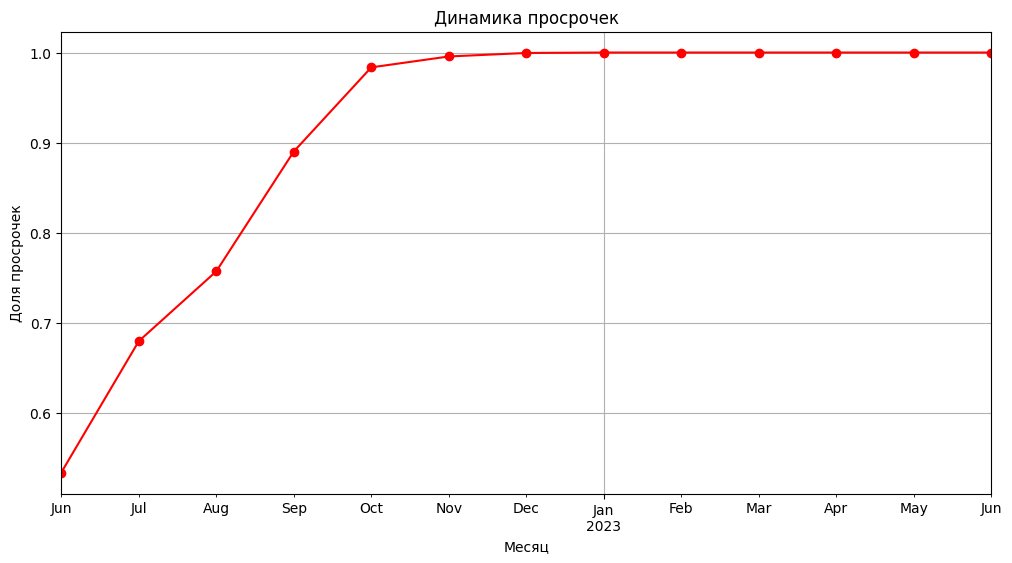

In [19]:
# Визуализация

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
delinquency_rate.plot(kind="line", marker="o", color="red", title="Динамика просрочек")
plt.xlabel("Месяц")
plt.ylabel("Доля просрочек")
plt.grid(True)
plt.show()

## Проверка тренда
Используем линейную регрессию для определения направления тренда

In [20]:
from sklearn.linear_model import LinearRegression

X = delinquency_rate.reset_index().index.values.reshape(-1, 1)
y = delinquency_rate.values

model = LinearRegression()
model.fit(X, y)



LinearRegression()

In [21]:
model.coef_

array([0.03152279])

In [22]:
trend = "рост" if model.coef_ > 0 else "снижение"
print(f"Тренд: {trend} просрочек.")

Тренд: рост просрочек.


## Анализ по сумме кредита

In [23]:
merged_with_orders = pd.merge(merged, orders_df[["order_id", "issued_sum"]], on="order_id")
merged_with_orders["issued_sum_group"] = pd.cut(merged_with_orders["issued_sum"], bins=5)
delinquency_by_sum = (
    merged_with_orders
    .dropna(subset=["issued_sum_group"]) 
    .groupby("issued_sum_group", observed=True)["is_delinquent"].mean()
)

In [24]:
# Сравнение с датой закрытия кредита

merged_closed = pd.merge(merged, orders_df[["order_id", "closed_at"]], on="order_id")
merged_closed['closed_at'] = pd.to_datetime(merged_closed['closed_at'])
merged_closed["closed_month"] = merged_closed["closed_at"].dt.to_period("M")
delinquency_closed = merged_closed.groupby("closed_month")["is_delinquent"].mean()

## Визуализация результатов


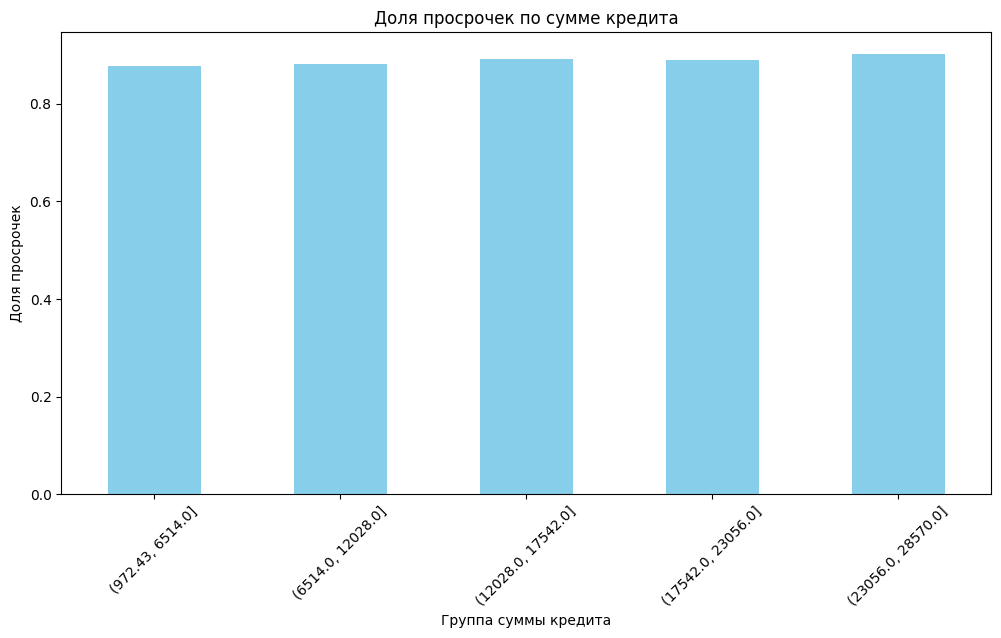

In [25]:

#Для анализа по сумме кредита
plt.figure(figsize=(12, 6))
delinquency_by_sum.plot(kind="bar", color="skyblue", title="Доля просрочек по сумме кредита")
plt.xlabel("Группа суммы кредита")
plt.ylabel("Доля просрочек")
plt.xticks(rotation=45)
plt.show()

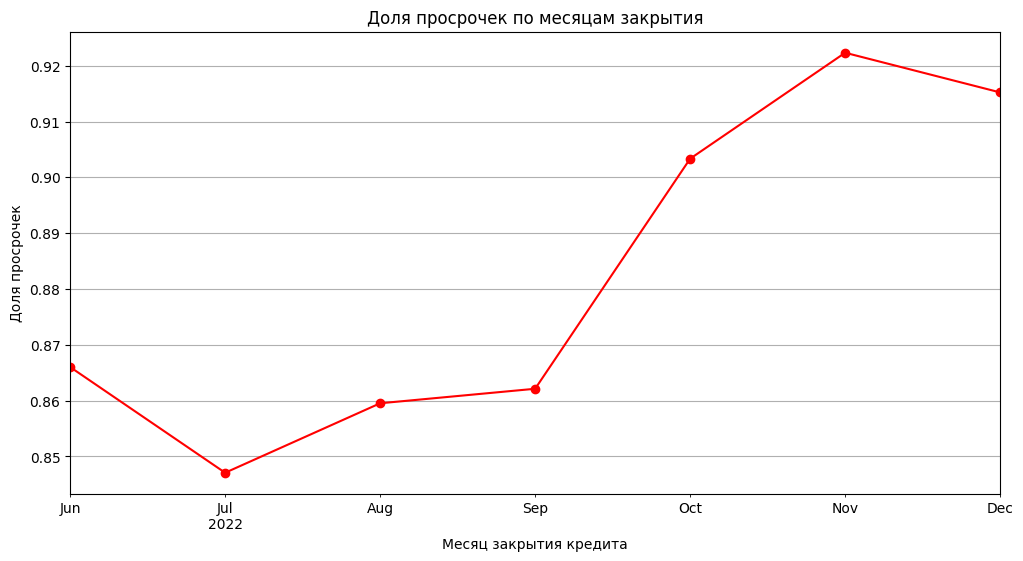

In [26]:
# Для анализа по дате закрытия
if not merged_closed.empty:
    plt.figure(figsize=(12, 6))
    delinquency_closed.plot(kind="line", marker="o", color="red", title="Доля просрочек по месяцам закрытия")
    plt.xlabel("Месяц закрытия кредита")
    plt.ylabel("Доля просрочек")
    plt.grid(True)
    plt.show()

In [27]:
# Общая доля просрочек
total_delinquency_rate = merged["is_delinquent"].mean()
print(f"Общая доля просрочек: {total_delinquency_rate:.2%}")

Общая доля просрочек: 88.20%


In [28]:
# Динамика по месяцам
print("Доля просрочек по месяцам:")
print(delinquency_rate)

Доля просрочек по месяцам:
plan_month
2022-06    0.533834
2022-07    0.679640
2022-08    0.757143
2022-09    0.890137
2022-10    0.983523
2022-11    0.995622
2022-12    0.999514
2023-01    1.000000
2023-02    1.000000
2023-03    1.000000
2023-04    1.000000
2023-05    1.000000
2023-06    1.000000
Freq: M, Name: is_delinquent, dtype: float64


In [29]:
# Распределение по сумме кредита
print("Доля просрочек по группам:")
print(delinquency_by_sum)

Доля просрочек по группам:
issued_sum_group
(972.43, 6514.0]      0.876800
(6514.0, 12028.0]     0.881576
(12028.0, 17542.0]    0.891299
(17542.0, 23056.0]    0.889986
(23056.0, 28570.0]    0.901635
Name: is_delinquent, dtype: float64
